# Endpoint exploration

In [1]:
from requests import get
request=get("https://ws.rosario.gob.ar/web/api/v1.0/ocurrencias")
datos=request.json()

## Exploríng the fetched data

In [2]:
datos.keys()

dict_keys(['data', 'meta', 'links'])

In [3]:
# One sample of event
datos["data"][0]

{'type': 'ocurrencias',
 'id': '56716',
 'attributes': {'id': 56716,
  'self': 'https://ws.rosario.gob.ar/web/api/v1.0/ocurrencias/56716',
  'name': 'VIII Congreso Internacional de Medicina Interna',
  'dateFull': {'value': '2019-05-16 08:00:00',
   'value2': '2019-05-16 18:00:00',
   'timezone': 'UTC',
   'timezone_db': 'UTC',
   'date_type': 'datetime'},
  'date_start': '2019-05-16 08:00:00',
  'date_end': '2019-05-16 18:00:00',
  'text': None,
  'ticket': '',
  'ticket_value': '',
  'eventual_name': 'CARBALLO LUIS CANDIDO 178',
  'eventual_direccion': 'CARBALLO LUIS CANDIDO 178',
  'eventual_coords': '5437750.797633288,6357559.703059582',
  'eventual_distrito': '438',
  'suspendida': False,
  'status': '1',
  'actividad': '56714',
  'regla': '56715',
  'regla_er': '56715'},
 'links': {'self': 'https://ws.rosario.gob.ar/web/api/v1.0/ocurrencias/56716'}}

In [4]:
datos['meta']

{'count': 70562}

In [5]:
datos['links']

{'self': 'https://ws.rosario.gob.ar/web/api/v1.0/ocurrencias?page%5Bnumber%5D=1',
 'first': 'https://ws.rosario.gob.ar/web/api/v1.0/ocurrencias?',
 'last': 'https://ws.rosario.gob.ar/web/api/v1.0/ocurrencias?page%5Bnumber%5D=1412',
 'next': 'https://ws.rosario.gob.ar/web/api/v1.0/ocurrencias?page%5Bnumber%5D=2'}

It seems that this belongs to a paginated response and we have in the attribute link that chains the rest of events.

## Experimentamos una mína manipulación con la data

In [6]:
# Simple form to flat the object.
[{k:v for k,v in element["attributes"].items() if type(v)!=dict } for element in datos["data"][:1]]

[{'id': 56716,
  'self': 'https://ws.rosario.gob.ar/web/api/v1.0/ocurrencias/56716',
  'name': 'VIII Congreso Internacional de Medicina Interna',
  'date_start': '2019-05-16 08:00:00',
  'date_end': '2019-05-16 18:00:00',
  'text': None,
  'ticket': '',
  'ticket_value': '',
  'eventual_name': 'CARBALLO LUIS CANDIDO 178',
  'eventual_direccion': 'CARBALLO LUIS CANDIDO 178',
  'eventual_coords': '5437750.797633288,6357559.703059582',
  'eventual_distrito': '438',
  'suspendida': False,
  'status': '1',
  'actividad': '56714',
  'regla': '56715',
  'regla_er': '56715'}]

# Buscamos los eventos del año 2023

In [7]:
# get_events fetches and filters events data from a specific API. It backtracks from the last page, retrieving events that haven't ended before a given year.

def crawl_events(url: str,year: int) -> tuple[str|None, list[dict]]:
    previous_events_found=False
    result=[]

    request=get(url)
    response_json=request.json()
    
    for event in response_json["data"]:
        if int(event["attributes"].get("date_end","0")[:4])<year:
            previous_events_found=True
            continue
        result.append({k:v for k,v in event["attributes"].items() if type(v)!=dict})

    next_page=None if previous_events_found else response_json['links']['previous'] 
    return next_page, result


def get_events(staring_url: str, year:int=2023) -> list[dict]:
    starting_request=get(staring_url)
    starting_data=starting_request.json()
    next_page=starting_data['links']['last']

    result=[]
    while next_page:
        next_page, data = crawl_events(next_page, year)
        result.extend(data)
    return result

events_2023 = get_events("https://ws.rosario.gob.ar/web/api/v1.0/ocurrencias",2023)


In [8]:
events_2023

[{'id': 237977,
  'self': 'https://ws.rosario.gob.ar/web/api/v1.0/ocurrencias/237977',
  'name': 'Recorridos por la Muestra Pisar la tierra, mirar el cielo',
  'date_start': '2023-07-29 15:00:00',
  'date_end': '2023-07-29 17:00:00',
  'text': None,
  'ticket': 'gratis',
  'ticket_value': '',
  'eventual_name': 'Complejo Astronómico Municipal',
  'eventual_direccion': 'DIARIO LA CAPITAL 1602',
  'eventual_coords': '5441636.02,6353589.92',
  'eventual_distrito': '437',
  'suspendida': False,
  'status': '1',
  'actividad': '237974',
  'regla': '237975',
  'regla_er': '237975'},
 {'id': 237978,
  'self': 'https://ws.rosario.gob.ar/web/api/v1.0/ocurrencias/237978',
  'name': 'Recorridos por la Muestra Pisar la tierra, mirar el cielo',
  'date_start': '2023-07-28 15:00:00',
  'date_end': '2023-07-28 17:00:00',
  'text': None,
  'ticket': 'gratis',
  'ticket_value': '',
  'eventual_name': 'Complejo Astronómico Municipal',
  'eventual_direccion': 'DIARIO LA CAPITAL 1602',
  'eventual_coords'

# ETL

In [57]:
import pandas as pd
import numpy as np
df=pd.DataFrame.from_dict(events_2023)
df.index=df['id']
df.drop(columns=['id'],inplace=True)
df.rename(columns={
        'self':'url'
    },inplace=True)
df.shape

(12859, 17)

In [58]:
df.head(5)

,url,name,date_start,date_end,text,ticket,ticket_value,eventual_name,eventual_direccion,eventual_coords,eventual_distrito,suspendida,status,actividad,regla,regla_er,place
id,,,,,,,,,,,,,,,,,
237977,https://ws.rosario.gob.ar/web/api/v1.0/ocurren...,"Recorridos por la Muestra Pisar la tierra, mir...",2023-07-29 15:00:00,2023-07-29 17:00:00,None,gratis,,Complejo Astronómico Municipal,DIARIO LA CAPITAL 1602,"5441636.02,6353589.92",437,False,1,237974,237975,237975,NaN
237978,https://ws.rosario.gob.ar/web/api/v1.0/ocurren...,"Recorridos por la Muestra Pisar la tierra, mir...",2023-07-28 15:00:00,2023-07-28 17:00:00,None,gratis,,Complejo Astronómico Municipal,DIARIO LA CAPITAL 1602,"5441636.02,6353589.92",437,False,1,237974,237975,237975,NaN
237979,https://ws.rosario.gob.ar/web/api/v1.0/ocurren...,"Recorridos por la Muestra Pisar la tierra, mir...",2023-07-27 15:00:00,2023-07-27 17:00:00,None,gratis,,Complejo Astronómico Municipal,DIARIO LA CAPITAL 1602,"5441636.02,6353589.92",437,False,1,237974,237975,237975,NaN
237980,https://ws.rosario.gob.ar/web/api/v1.0/ocurren...,"Recorridos por la Muestra Pisar la tierra, mir...",2023-07-23 15:00:00,2023-07-23 17:00:00,None,gratis,,Complejo Astronómico Municipal,DIARIO LA CAPITAL 1602,"5441636.02,6353589.92",437,False,1,237974,237975,237975,NaN
237981,https://ws.rosario.gob.ar/web/api/v1.0/ocurren...,"Recorridos por la Muestra Pisar la tierra, mir...",2023-07-26 15:00:00,2023-07-26 17:00:00,None,gratis,,Complejo Astronómico Municipal,DIARIO LA CAPITAL 1602,"5441636.02,6353589.92",437,False,1,237974,237975,237975,NaN


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12859 entries, 237977 to 216745
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   url                 12859 non-null  object 
 1   name                12859 non-null  object 
 2   date_start          12859 non-null  object 
 3   date_end            12859 non-null  object 
 4   text                28 non-null     object 
 5   ticket              12859 non-null  object 
 6   ticket_value        12859 non-null  object 
 7   eventual_name       12221 non-null  object 
 8   eventual_direccion  12218 non-null  object 
 9   eventual_coords     12221 non-null  object 
 10  eventual_distrito   12221 non-null  object 
 11  suspendida          12859 non-null  bool   
 12  status              12859 non-null  object 
 13  actividad           12859 non-null  object 
 14  regla               12859 non-null  object 
 15  regla_er            11293 non-null  object 
 16

In [60]:
# Convert date_start and date_end to datetime
df.date_start=pd.to_datetime(df.date_start)
df.date_end=pd.to_datetime(df.date_end)

In [61]:
df.place.value_counts()

Series([], Name: place, dtype: int64)

In [62]:
# remove empty column
df.drop(columns="place",inplace=True)

In [63]:
df.actividad.value_counts()

226449    529
226450    452
226446    448
226447    419
226448    384
         ... 
232413      1
232411      1
232409      1
232407      1
216740      1
Name: actividad, Length: 1699, dtype: int64

In [64]:
df.status.value_counts()

1    12859
Name: status, dtype: int64

In [65]:
df.drop(columns="status",inplace=True)

In [66]:
df.suspendida.value_counts()

False    12827
True        32
Name: suspendida, dtype: int64

In [67]:
df.actividad=df.actividad.astype(np.number)

#### ticket_value

In [68]:
df.ticket_value.unique()

array(['', '$400', 'Paga $200 (menores de 4 años, gratis)', '$2400',
       'Desde $2300', 'Desde $6000', '$1500', '1500', '$ 400', '$2500',
       'Desde $2500', '$4500', '$8000', '$5000', 'Desde $2000',
       'Desde $4000', '6000', '$800', '$1700', 'Desde $5500', '$2000',
       '$200 (menores de 4 años, gratis)', 'Desde $3690', '7000', '$3000',
       '$9000', 'desde $1500', 'Desde $3800', 'Desde $3500', '$700',
       'Desde $2915', '1800', 'Desde $4400', 'Desde $3000', '2000',
       'Desde 1210$', 'Desde $1500', '$7840', 'Desde $3450',
       'Desde $6400', 'Desde $8000', 'Desde $6900', 'Desde $5750',
       '$4600', '$6000', '$100 (menores de 4 años gratis)', 'Desde $4510',
       '$1000', 'Desde $4500', '3000', '$4000',
       'Paga $100 (menores de 4 años, gratis)',
       '$100 (menores de 4 años, gratis)',
       '$ 100 (menores de 4 años, gratis)', '$6900',
       ' $100 (menores de 4 años gratis) ',
       '$100 (menores de 4 años gratis) ', '$3500', '500 - 700',
       '

In [69]:
import numpy as np
df.ticket_value=df.ticket_value.apply(lambda x: x if x else np.nan)

#### ticket

In [70]:
import numpy as np

def obtener_tipo(valor:str):
    if not valor or pd.isna(valor):
        return np.nan
    
    v=valor.lower()
    if v == 'entradas agotadas':
        return 'AGOTADAS'
    elif 'por mes' in v or 'mensual' in v:
        return 'POR_MES'
    elif 'total' in v:
        return 'TOTAL'
    elif 'clase' in v:
        return 'POR_VEZ'
    elif 'entrada sin cargo' in v:
        return 'GRATIS'
    elif 'desde' in v:
        return 'DESDE'

    return 'FIJO'


import re

def obtener_valor(txt: str):
    if not txt or pd.isna(txt):
        return np.nan
    
    if txt == 'ENTRADAS AGOTADAS' or \
        not txt.strip() or \
        "ntrada sin cargo" in txt:
        return np.nan
    
    txt = txt.replace('$','').replace('.','').replace(',','').strip()
    valores = re.findall(r'[\d]+', txt)  # Extraer dígitos y puntos decimales
    valor = valores[0] if valores else np.nan
    return int(valor)
    

def obtener_paga_menor_4(valor):
    if not valor or pd.isna(valor):
        return True
    return 'años' not in valor

df['ticket_tipo'] = df['ticket_value'].apply(obtener_tipo)
df['ticket_valor'] = df['ticket_value'].apply(obtener_valor)
df['ticket_paga_menor_4'] = df['ticket_value'].apply(obtener_paga_menor_4)

df['ticket_valor'].fillna(0, inplace=True)

In [71]:
df.ticket.value_counts()

gratis           6781
                 4358
paga             1591
gorra              93
no_especifica      36
Name: ticket, dtype: int64

In [72]:
df.ticket=df.ticket.apply(lambda x: x if x in ["gratis", "paga", "gorra"] else np.nan)
df.ticket.value_counts()

gratis    6781
paga      1591
gorra       93
Name: ticket, dtype: int64

In [73]:
df.ticket.unique()

array(['gratis', 'paga', nan, 'gorra'], dtype=object)

In [74]:
df.reset_index(inplace=True)
df.to_parquet('events_2023.parquet')

# Exploring
let's see some fields of this dataframe

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12859 entries, 0 to 12858
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   12859 non-null  int64         
 1   url                  12859 non-null  object        
 2   name                 12859 non-null  object        
 3   date_start           12859 non-null  datetime64[ns]
 4   date_end             12859 non-null  datetime64[ns]
 5   text                 28 non-null     object        
 6   ticket               8465 non-null   object        
 7   ticket_value         1457 non-null   object        
 8   eventual_name        12221 non-null  object        
 9   eventual_direccion   12218 non-null  object        
 10  eventual_coords      12221 non-null  object        
 11  eventual_distrito    12221 non-null  object        
 12  suspendida           12859 non-null  bool          
 13  actividad            12859 non-

In [76]:
pd.concat([df[df.ticket.isin(["gratis"])].head(2),(df[df.ticket.isin(["gorra","gratis"])].head(2))])

,id,url,name,date_start,date_end,text,ticket,ticket_value,eventual_name,eventual_direccion,eventual_coords,eventual_distrito,suspendida,actividad,regla,regla_er,ticket_tipo,ticket_valor,ticket_paga_menor_4
0,237977,https://ws.rosario.gob.ar/web/api/v1.0/ocurren...,"Recorridos por la Muestra Pisar la tierra, mir...",2023-07-29 15:00:00,2023-07-29 17:00:00,None,gratis,NaN,Complejo Astronómico Municipal,DIARIO LA CAPITAL 1602,"5441636.02,6353589.92",437,False,237974.0,237975,237975,NaN,0.0,True
1,237978,https://ws.rosario.gob.ar/web/api/v1.0/ocurren...,"Recorridos por la Muestra Pisar la tierra, mir...",2023-07-28 15:00:00,2023-07-28 17:00:00,None,gratis,NaN,Complejo Astronómico Municipal,DIARIO LA CAPITAL 1602,"5441636.02,6353589.92",437,False,237974.0,237975,237975,NaN,0.0,True
0,237977,https://ws.rosario.gob.ar/web/api/v1.0/ocurren...,"Recorridos por la Muestra Pisar la tierra, mir...",2023-07-29 15:00:00,2023-07-29 17:00:00,None,gratis,NaN,Complejo Astronómico Municipal,DIARIO LA CAPITAL 1602,"5441636.02,6353589.92",437,False,237974.0,237975,237975,NaN,0.0,True
1,237978,https://ws.rosario.gob.ar/web/api/v1.0/ocurren...,"Recorridos por la Muestra Pisar la tierra, mir...",2023-07-28 15:00:00,2023-07-28 17:00:00,None,gratis,NaN,Complejo Astronómico Municipal,DIARIO LA CAPITAL 1602,"5441636.02,6353589.92",437,False,237974.0,237975,237975,NaN,0.0,True


In [77]:
df[df.ticket.isin(["paga"])].head(2)

,id,url,name,date_start,date_end,text,ticket,ticket_value,eventual_name,eventual_direccion,eventual_coords,eventual_distrito,suspendida,actividad,regla,regla_er,ticket_tipo,ticket_valor,ticket_paga_menor_4
15,237997,https://ws.rosario.gob.ar/web/api/v1.0/ocurren...,Taller de Pop Up,2023-07-21 15:00:00,2023-07-21 17:00:00,None,paga,$400,Museo de Arte Decorativo Firma y Odilo Estevez,SANTA FE 748,"5440805.12347424,6354961.3519457",437,False,237996.0,0,NaN,FIJO,400.0,True
16,237999,https://ws.rosario.gob.ar/web/api/v1.0/ocurren...,Taller Dibujando historias ¿Qué historias secr...,2023-07-28 15:00:00,2023-07-28 17:00:00,None,paga,$400,Museo de Arte Decorativo Firma y Odilo Estevez,SANTA FE 748,"5440805.12347424,6354961.3519457",437,False,237998.0,0,NaN,FIJO,400.0,True


In [106]:
df.ticket.value_counts()

gratis    6781
paga      1591
gorra       93
Name: ticket, dtype: int64

ticket  ticket_tipo
gratis  NaN            6781
NaN     NaN            4394
paga    FIJO           1182
        NaN             134
        DESDE           123
        POR_MES         102
gorra   NaN              93
paga    TOTAL            38
        POR_VEZ          10
        AGOTADAS          1
        GRATIS            1
Name: id, dtype: int64

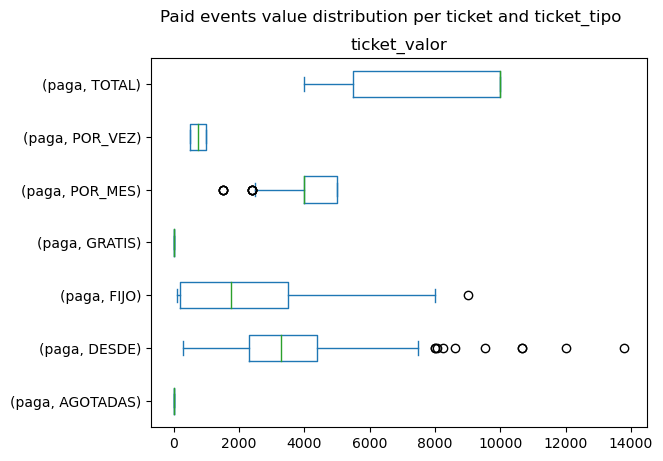

In [119]:
df.plot.box(by=["ticket", "ticket_tipo"],column="ticket_valor", vert=False, subplots=True, title="Paid events value distribution per ticket and ticket_tipo")
df.groupby(["ticket","ticket_tipo"], dropna=False).id.count().sort_values(ascending=False)

<AxesSubplot: title={'center': 'Paid events value distribution'}, ylabel='Frequency'>

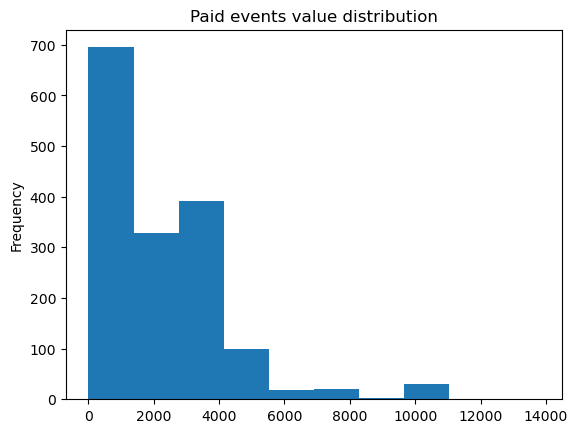

In [108]:
df[df.ticket=="paga"].ticket_valor.plot.hist(title="Paid events value distribution")